In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

In [2]:
from utils import extract_page_text_content, launch_chromedriver
from models import HtmlPage, TextContainer
from pathlib import Path
from PIL import Image

pdf_samples_base = Path('../tests/data/sample_html_page/')
pdf_path = pdf_samples_base / "page4.html"

In [3]:
browser = launch_chromedriver()

In [4]:
page = extract_page_text_content(browser, pdf_path.resolve())

In [10]:
def draw_page_elements(ax, page: HtmlPage, png_path: str, min_text_length=30):
  page_image = Image.open(png_path)
  page_image = page_image.resize((page.width, page.height), Image.ANTIALIAS)
  # _, ax = plt.subplots(dpi=150)

  # layout = PdfLayout([page], min_text_length=min_text_length)
  # (left_bbox, right_bbox, top_bbox, bottom_bbox) = layout.find_surrounding_bboxes()

  # # contrains in Y axis for finding text
  # text_area = patches.Rectangle((0, layout.text_y_min),
  #                             layout.page_width,
  #                             layout.text_y_max-layout.text_y_min,
  #                             linewidth=0,
  #                             edgecolor='none',
  #                             facecolor='y',
  #                             alpha=0.2)
  # ax.add_patch(text_area)

  # DIVs with text on page, red ones are smaller than minimum length
  for text_box in page.text_containers:
    color = 'b' if len(text_box.text) > min_text_length else 'r'
    rect = patches.Rectangle((text_box.x0, text_box.y0),
                              text_box.width, text_box.height,
                              linewidth=1,
                              edgecolor=color,
                              facecolor='none',
                              alpha=0.4)
    ax.add_patch(rect)

  # minimum x for the most common x0 in text boxes
  # ax.plot([layout.text_x_common_min, layout.text_x_common_min],
  #         [0, page.height],
  #         color="g", linestyle='--')

  # # minimum x0
  # ax.plot([layout.text_x_min, layout.text_x_min],
  #         [0, page.height],
  #         color="g", linestyle='--')

  # for bbox in (left_bbox, right_bbox, top_bbox, bottom_bbox):
  #   rect = patches.Rectangle((bbox.x0, bbox.y0),
  #                             bbox.width, bbox.height,
  #                             linewidth=0,
  #                             edgecolor='none',
  #                             facecolor='gray',
  #                             alpha=0.5)
  #   ax.add_patch(rect)          

  ax.imshow(page_image)

/tmp/ipykernel_2986653/2515450070.py:3: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  page_image = page_image.resize((page.width, page.height), Image.ANTIALIAS)


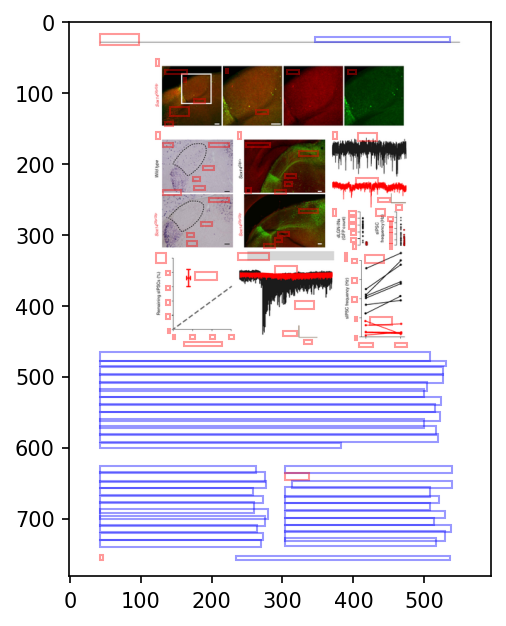

In [13]:
fig, ax = plt.subplots(dpi=150)
draw_page_elements(ax, page, pdf_samples_base / 'page4.png', 30)

## Decipher code

In [4]:
import main
import utils

base_test_folder = Path('../tests')
output = base_test_folder / "output"
pdf1_path = base_test_folder / "data" / "pdf-1.pdf"
# xpdf_path  = base_test_folder / "output"



In [5]:
pil_images = main.fetch_pages_as_images(pdf_path=pdf1_path.resolve(), base_folder=output)

In [6]:
xpdf_folder_path = utils.pdf2html(pdf1_path.resolve(), output.resolve(), "pdf1")
# pages = main.get_pages(xpdf_path)

In [7]:
pages = main.get_pages(Path(xpdf_folder_path))

In [100]:
def merge_left_padded_points(sorted_points: list[tuple[int, int]], padding_threshold=10) -> list[tuple[int, int]]:
    """ Update the sorted counts by merging padded text elements """
    left_points = sorted_points.copy()
    i = 0
    while i < len(left_points):
        j = i + 1
        while j < len(left_points):
            if abs(left_points[i][0] - left_points[j][0]) <= padding_threshold:
                left_points[i] = (left_points[i][0], left_points[i][1] + left_points[j][1])
                del left_points[j]
            else:
                j = j + 1
        i = i + 1
    return sorted(left_points, key=lambda x: x[1], reverse=True)

def get_columns_coordinates(sorted_left_points, row_width, page_width):
    mode_first_left_point = sorted_left_points[0][1]
    if float(mode_first_left_point) / len(sorted_left_points) > .75 or float(row_width) / page_width > .5:
        return [sorted_left_points[0][0]]
    else:
        # find starting point for second column
        for i in range(1, len(sorted_left_points)):
            if abs(sorted_left_points[i][0] - sorted_left_points[0][0]) > row_width:
                return [
                    min(sorted_left_points[i][0], sorted_left_points[0][0]),
                    max(sorted_left_points[i][0], sorted_left_points[0][0]),
                ]


def calculate_document_layout(pages: list[HtmlPage], width_threshold=30):
    """ Implements the document layout acquisition procedure from section 2.2 """
    x0s = [y.x0 for x in pages for y in x.text_containers if y.width > width_threshold]
    y0s = [y.y0 for x in pages for y in x.text_containers if y.width > width_threshold]
    x1s = [y.x1 for x in pages for y in x.text_containers if y.width > width_threshold]
    widths = [y.width for x in pages for y in x.text_containers if y.width > width_threshold]
    heights = [y.height for x in pages for y in x.text_containers if y.width > width_threshold]

    # sorting by most occurent value (mode) using tuples (width, count(width))
    sorted_x0s = sorted([(i, x0s.count(i)) for i in set(x0s)], key=lambda x: x[1], reverse=True)
    sorted_widths = sorted([(i, widths.count(i)) for i in set(widths)], key=lambda x: x[1], reverse=True)
    sorted_heights = sorted([(i, heights.count(i)) for i in set(heights)], key=lambda x: x[1], reverse=True)  

    row_height = sorted_heights[0][0]
    row_width = sorted_widths[0][0]  

    # consider padding
    sorted_x0s = merge_left_padded_points(sorted_x0s)
    # calculate number of columns
    columns_x0 = get_columns_coordinates(sorted_x0s, row_width, pages[0].width)
    number_columns = len(columns_x0)

    #   x_left_most = sorted_x0s[0][0] # min(x0s)
    #   x_right_most = max(x1s) 
    #   content_width = abs(x_right_most - x_left_most)
    #   content_region_y0 = max(0, min(y0s))
    #   content_region_y1 = min(pages[0].height, max(y0s)) # plus height?
    #   content_region = [x_left_most, content_region_y0, x_right_most, content_region_y1]

    content_region_y0 = max(0, min(y0s))
    content_region_y1 = min(pages[0].height, max(y0s)) 
    text_layout = [content_region_y0, content_region_y1]

    left_bar = min(x0s)
    right_bar = max(x1s)
    if left_bar < 20 * row_height:
        print("1")
        c_x0 = left_bar
        c_x1 = min(pages[0].width - 2 * row_height, right_bar)

        if text_layout[0] < 15 * row_height and text_layout[1] > 15 * row_height:
            c_y0 = text_layout[0]
            c_y1 = text_layout[1]
        else:
            c_y0 = row_height
            c_y1 = pages[0].height - row_height
    else:
        print("2")
        c_x0 = row_height #? 
        c_x1 = pages[0].width - row_height # why not width
        c_y0 = row_height
        c_y1 = pages[0].height - row_height
    content_region = [c_x0, c_y0, c_x1, c_y1]

    return content_region, row_width, row_height


In [101]:
content_region, row_width, row_height = calculate_document_layout(pages)
content_region


1


[10, 33, 551, 782]

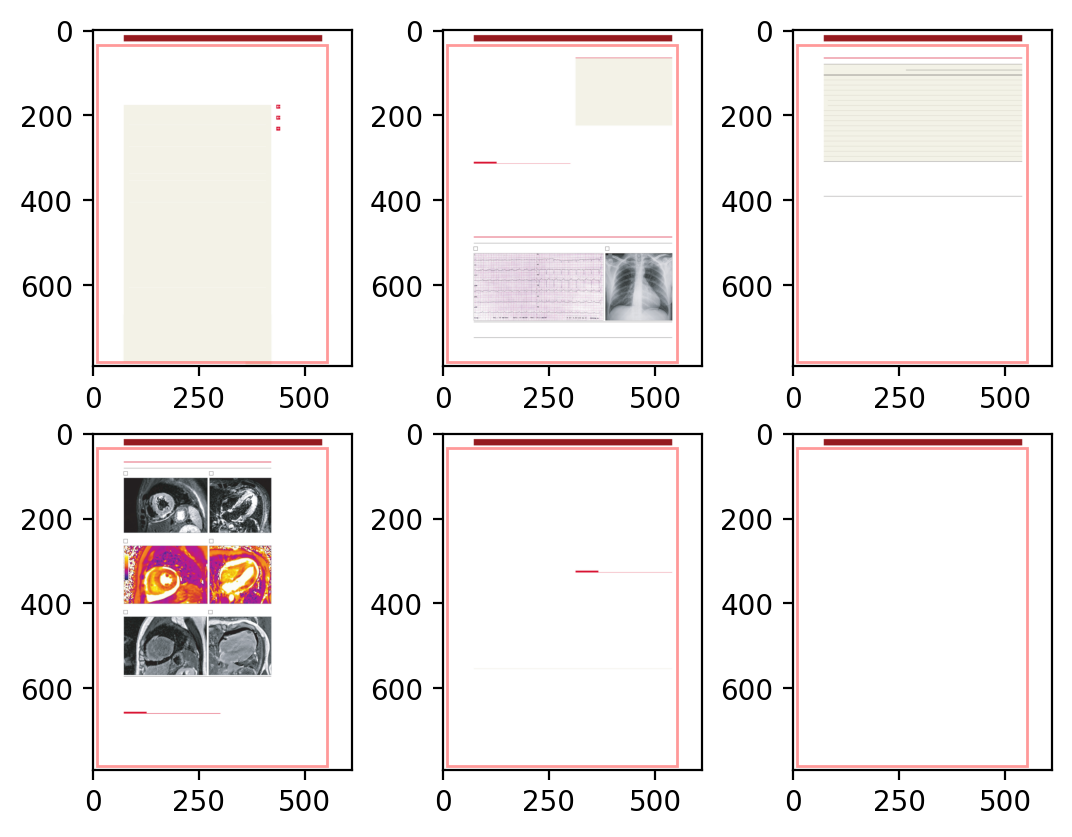

In [97]:

def draw_content_region(ax, content_region: list[int], png_path: str):
  page_image = Image.open(png_path)
  page_image = page_image.resize((page.width, page.height))
  
  width = content_region[2] - content_region[0]
  height = content_region[3] - content_region[1]
  rect = patches.Rectangle((content_region[0], content_region[1]),
                            width, height,
                            linewidth=1,
                            edgecolor='red',
                            facecolor='none',
                            alpha=0.4)
  ax.add_patch(rect)
  ax.imshow(page_image)


number_cols = 3
number_rows = int(len(pages) / number_cols) 

_, ax = plt.subplots(number_rows, number_cols, dpi=200)

for idx, page in enumerate(pages):
  page_name = f"page{idx+1}.png"
  png_path = (Path(xpdf_folder_path) / page_name).resolve()

  col = idx % number_cols
  row = int(idx / number_cols)  
  draw_content_region(ax[row][col], content_region, png_path)  
  

## Graphical content detection

In [8]:
from os import listdir
import cv2
import numpy as np

def calc_img_scale(image, page_width, page_height):
    # the PNG may be bigger than the html size
    height, width, _ = image.shape
    if height > width:
      return float(height) / page_height
    else:
      return float(width) / page_width

def overlap_ratio_based(box1, box2):
    # overlap ratio based on box1
    box1_x0 = box1[0]
    box1_y0 = box1[1]
    box1_x1 = box1[0] + box1[2]
    box1_y1 = box1[1] + box1[3]

    box2_x0 = box2[0]
    box2_y0 = box2[1]
    box2_x1 = box2[0] + box2[2]
    box2_y1 = box2[1] + box2[3]

    SI = max(0, min(box1_x1, box2_x1) - max(box1_x0, box2_x0)) * max(
        0, min(box1_y1, box2_y1) - max(box1_y0, box2_y0)
    )
    box1_area = box1[2] * box1[3]    
    if box1_area == 0:
        overlap_ratio = 0
    else:
        overlap_ratio = float(SI) / box1_area
    return overlap_ratio

def detect_boxes(pages: list[HtmlPage], xpdf_path: str):    
    page_width = pages[0].width
    page_height = pages[0].height

    images = []

    for page in pages:
      png_path = str((Path(xpdf_path) / page.img_name).resolve())
      print(png_path)
      page_image = cv2.imread(png_path)      
      scaling = calc_img_scale(page_image, page_width, page_height)

      # identify boxes with text for figures or tables
      table_boxes = []
      figure_boxes = []
      for text_container in page.text_containers:
        text = text_container.text.lower().strip()
        if text.startswith("table") or text.startswith("box"):
          table_boxes.append(text_container)
        elif text.startswith("fig"):
          figure_boxes.append(text_container)
        else:
          text = text[:6].replace(" ", "")
          if text.startswith("fig"): figure_boxes.append(text_container)
      
      page_image_gray = cv2.cvtColor(page_image, cv2.COLOR_BGR2GRAY)
      _, thresh = cv2.threshold(page_image_gray, 240, 255, cv2.THRESH_BINARY_INV)
      kernel = np.ones((5, 5), np.uint8)
      dilation = cv2.dilate(thresh, kernel, iterations=1)
      contours, _ = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
      new_thresh = np.zeros(thresh.shape, dtype=np.uint8)

      for cnt in contours:
        bbox = cv2.boundingRect(cnt)
        p_bbox = [int(float(x) / scaling) for x in bbox]
        box_image = 0
        for caption_box in figure_boxes:
            box_image = box_image + overlap_ratio_based(caption_box.to_bbox(), p_bbox)
        if box_image < 0.5:
            cv2.drawContours(new_thresh, [cnt], 0, 255, -1)
      
      images.append(new_thresh)

    return images

# detect_boxes(xpdf_folder_path)
    

In [24]:
pages[0].height

792

In [15]:
page = pages[3]

# caption information
table_boxes = []
figure_boxes = []
for text_container in page.text_containers:
  text = text_container.text.lower().strip()
  if text.startswith("table") or text.startswith("box"):
    table_boxes.append(text_container)
  elif text.startswith("fig"):
    figure_boxes.append(text_container)
  else:
    text = text[:6].replace(" ", "")
    if text.startswith("fig"): figure_boxes.append(text_container)
print(figure_boxes)

# figure processing
png_path = str((Path(xpdf_folder_path) / page.img_name).resolve())
page_image = cv2.imread(png_path)
page_image_gray = cv2.cvtColor(page_image, cv2.COLOR_BGR2GRAY)

page_width = 612
page_height = 792
row_height = 10 # only need this from page layout?
scaling = calc_img_scale(page_image, page_width, page_height)

_, thresh = cv2.threshold(page_image_gray, 240, 255, cv2.THRESH_BINARY_INV)
kernel = np.ones((5, 5), np.uint8)
dilation = cv2.dilate(thresh, kernel, iterations=1)
contours, _ = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
canvas_with_contours = np.zeros(thresh.shape, dtype=np.uint8)

for cnt in contours:
  cnt_bbox = cv2.boundingRect(cnt)
  scaled_cnt_bbox = [int(float(x) / scaling) for x in cnt_bbox]
  overlap = 0
  for caption_box in figure_boxes:
     overlap += overlap_ratio_based(caption_box.to_bbox(), scaled_cnt_bbox)
  if overlap < 0.5:
      cv2.drawContours(canvas_with_contours, [cnt], 0, 255, -1)

contours, _ = cv2.findContours(canvas_with_contours, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
potential_bbox = []
for cnt in contours:
  cnt_bbox = cv2.boundingRect(cnt)
  thresh_for_figure = row_height * scaling * 1.5
  # iterate and discard bounding boxes based on whether they overlap with the contour boxes


cv2.namedWindow("window", cv2.WINDOW_NORMAL)
imS = cv2.resize(canvas_with_contours, (page_width, page_height))  
cv2.imshow('window', imS)
cv2.waitKey(0)
cv2.destroyAllWindows()

[TextContainer(x0=72, y0=70, x1=219, y1=80, width=147, height=10, text='Figure 2. 1.5-T Cardiac Magnetic Resonance Imaging')]
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.0
overlap 0.

QObject::moveToThread: Current thread (0x5588b223ae40) is not the object's thread (0x5588b21c5b10).
Cannot move to target thread (0x5588b223ae40)

QObject::moveToThread: Current thread (0x5588b223ae40) is not the object's thread (0x5588b21c5b10).
Cannot move to target thread (0x5588b223ae40)

QObject::moveToThread: Current thread (0x5588b223ae40) is not the object's thread (0x5588b21c5b10).
Cannot move to target thread (0x5588b223ae40)

QObject::moveToThread: Current thread (0x5588b223ae40) is not the object's thread (0x5588b21c5b10).
Cannot move to target thread (0x5588b223ae40)

QObject::moveToThread: Current thread (0x5588b223ae40) is not the object's thread (0x5588b21c5b10).
Cannot move to target thread (0x5588b223ae40)

QObject::moveToThread: Current thread (0x5588b223ae40) is not the object's thread (0x5588b21c5b10).
Cannot move to target thread (0x5588b223ae40)

QObject::moveToThread: Current thread (0x5588b223ae40) is not the object's thread (0x5588b21c5b10).
Cannot move to tar

In [9]:
images = detect_boxes(pages, xpdf_folder_path)

/home/jtt/repos/PDFigCapX/pdfigcapx/tests/output/pdf1/page3.png
/home/jtt/repos/PDFigCapX/pdfigcapx/tests/output/pdf1/page1.png
/home/jtt/repos/PDFigCapX/pdfigcapx/tests/output/pdf1/page2.png
/home/jtt/repos/PDFigCapX/pdfigcapx/tests/output/pdf1/page4.png
/home/jtt/repos/PDFigCapX/pdfigcapx/tests/output/pdf1/page6.png
/home/jtt/repos/PDFigCapX/pdfigcapx/tests/output/pdf1/page5.png


In [11]:
cv2.imshow('contours', images[1])
cv2.waitKey(0)
cv2.destroyAllWindows()

QObject::moveToThread: Current thread (0x561679ded560) is not the object's thread (0x56167a8bd260).
Cannot move to target thread (0x561679ded560)

QObject::moveToThread: Current thread (0x561679ded560) is not the object's thread (0x56167a8bd260).
Cannot move to target thread (0x561679ded560)

QObject::moveToThread: Current thread (0x561679ded560) is not the object's thread (0x56167a8bd260).
Cannot move to target thread (0x561679ded560)

QObject::moveToThread: Current thread (0x561679ded560) is not the object's thread (0x56167a8bd260).
Cannot move to target thread (0x561679ded560)

QObject::moveToThread: Current thread (0x561679ded560) is not the object's thread (0x56167a8bd260).
Cannot move to target thread (0x561679ded560)

QObject::moveToThread: Current thread (0x561679ded560) is not the object's thread (0x56167a8bd260).
Cannot move to target thread (0x561679ded560)

QObject::moveToThread: Current thread (0x561679ded560) is not the object's thread (0x56167a8bd260).
Cannot move to tar